In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d nafishamoin/bangladeshi-crops-disease-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
bangladeshi-crops-disease-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/bangladeshi-crops-disease-dataset.zip

In [ ]:
!mkdir  /content/CornDisease


mkdir: cannot create directory ‘/content/CornDisease’: File exists


In [ ]:
!mv /content/CropDisease/Crop___DIsease/Corn___Common_Rust /content/CornDisease/
!mv /content/CropDisease/Crop___DIsease/Corn___Gray_Leaf_Spot /content/CornDisease/
!mv /content/CropDisease/Crop___DIsease/Corn___Healthy /content/CornDisease/
!mv /content/CropDisease/Crop___DIsease/Corn___Leaf_Blight /content/CornDisease/

mv: cannot move '/content/CropDisease/Crop___DIsease/Corn___Common_Rust' to '/content/CornDisease/Corn___Common_Rust': Directory not empty
mv: cannot move '/content/CropDisease/Crop___DIsease/Corn___Gray_Leaf_Spot' to '/content/CornDisease/Corn___Gray_Leaf_Spot': Directory not empty
mv: cannot move '/content/CropDisease/Crop___DIsease/Corn___Healthy' to '/content/CornDisease/Corn___Healthy': Directory not empty
mv: cannot move '/content/CropDisease/Crop___DIsease/Corn___Leaf_Blight' to '/content/CornDisease/Corn___Leaf_Blight': Directory not empty


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense , Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow.keras.models import load_model

In [ ]:
batch_size = 32
data_path = "/content/CornDisease"
num_classes = 4
num_epochs = 10

Image_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2
)


train_generator = Image_datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'training'
)


validation_generator = Image_datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'validation'
)


Found 11708 images belonging to 4 classes.
Found 2924 images belonging to 4 classes.


In [ ]:
train_generator.class_indices

{'Corn___Common_Rust': 0,
 'Corn___Gray_Leaf_Spot': 1,
 'Corn___Healthy': 2,
 'Corn___Leaf_Blight': 3}

In [ ]:
class_names = list(train_generator.class_indices.keys())
class_names

['Corn___Common_Rust',
 'Corn___Gray_Leaf_Spot',
 'Corn___Healthy',
 'Corn___Leaf_Blight']

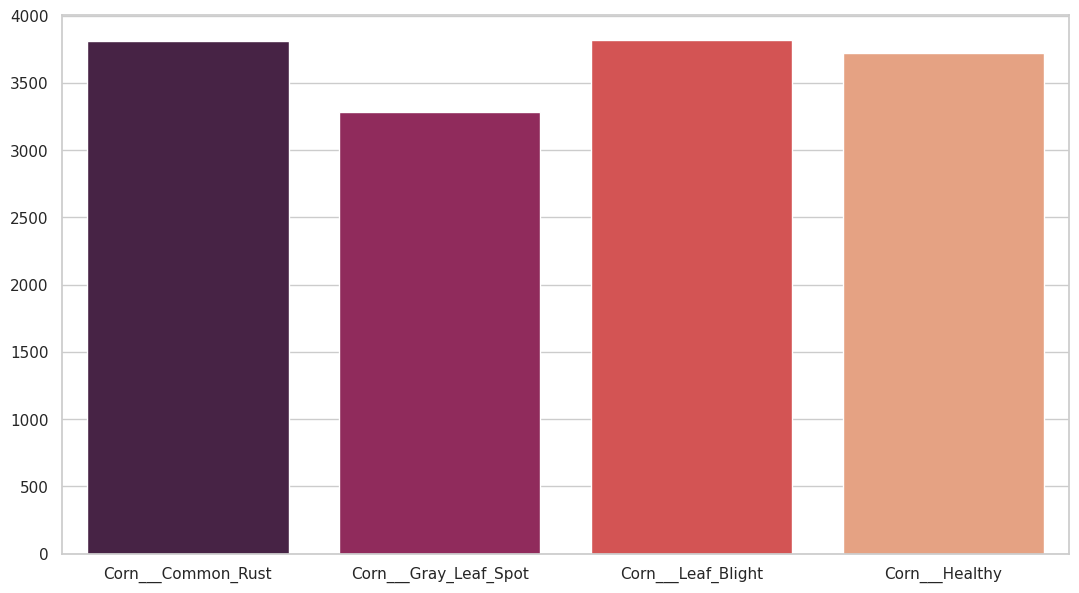

In [ ]:
import os
import glob as gb
sns.set_theme(style="whitegrid")
Data_imbalance = []
x_ax = []
for folder in os.listdir(data_path):
    files = gb.glob(pathname=str(data_path + "/" + folder +"/*.*"))
    Data_imbalance.append(len(files))
    x_ax.append(folder)
plt.figure(figsize=(13,7))
sns.barplot(x=x_ax, y=Data_imbalance, palette="rocket")
plt.show()

In [ ]:
total = 0
for i in range(0,len(Data_imbalance)) :
    total +=Data_imbalance[i]

weight_for_0 = (1 / Data_imbalance[0]) * (total / 4.0)
weight_for_1 = (1 / Data_imbalance[1]) * (total / 4.0)
weight_for_2 = (1 / Data_imbalance[2]) * (total / 4.0)
weight_for_3 = (1 / Data_imbalance[3]) * (total / 4.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))

Weight for class 0: 0.96
Weight for class 1: 1.11
Weight for class 2: 0.96
Weight for class 3: 0.98


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

# Add custom layers for fine-tuning
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)  # Replace 'num_classes' with the number of classes in your dataset

# Create the final model for fine-tuning
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) ,
    class_weight = class_weight
)

Epoch 1/10
366/366 [==============================] - 228s 547ms/step - loss: 0.2215 - accuracy: 0.9199 - val_loss: 2.0467 - val_accuracy: 0.6662
Epoch 2/10
366/366 [==============================] - 199s 544ms/step - loss: 0.0690 - accuracy: 0.9777 - val_loss: 1.1222 - val_accuracy: 0.7517
Epoch 3/10
366/366 [==============================] - 202s 550ms/step - loss: 0.0453 - accuracy: 0.9847 - val_loss: 1.2916 - val_accuracy: 0.7473
Epoch 4/10
366/366 [==============================] - 203s 554ms/step - loss: 0.0325 - accuracy: 0.9894 - val_loss: 0.7239 - val_accuracy: 0.8680
Epoch 5/10
366/366 [==============================] - 203s 556ms/step - loss: 0.0339 - accuracy: 0.9893 - val_loss: 0.1871 - val_accuracy: 0.9490
Epoch 6/10
366/366 [==============================] - 206s 562ms/step - loss: 0.0274 - accuracy: 0.9914 - val_loss: 0.3356 - val_accuracy: 0.9254
Epoch 7/10
366/366 [==============================] - 204s 558ms/step - loss: 0.0277 - accuracy: 0.9913 - val_loss: 0.1235 -

In [ ]:
!mkdir /content/drive/MyDrive/SIH-Models/Corn

In [ ]:

# Save the fine-tuned model for later use
model.save('/content/drive/MyDrive/SIH-Models/Corn/corn_mobilenetv2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Plots saved as '/content/drive/MyDrive/SIH-Models/Corn/train and loss'


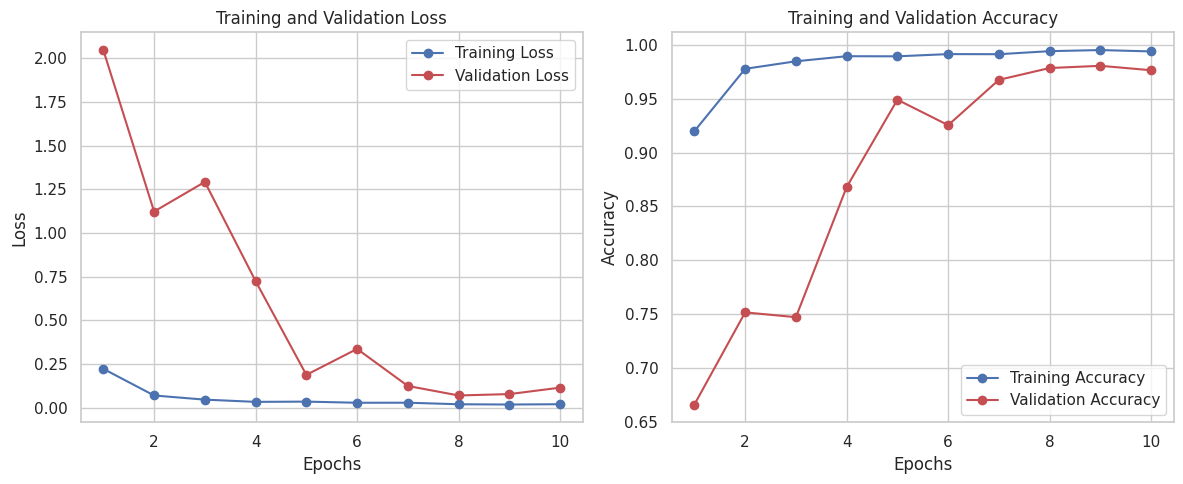

In [ ]:
import os
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(history, save_dir=None, filename=None):
    # Extract the loss and accuracy values from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Get the number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    # Save the figure if save_dir and filename are provided
    if save_dir and filename:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, filename)
        plt.savefig(save_path)
        print(f"Plots saved as '{save_path}'")

    plt.show()

plot_loss_and_accuracy(history ,"/content/drive/MyDrive/SIH-Models/Corn", "train and loss" )

In [ ]:

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i in range(len(validation_generator)):
    true_labels = validation_generator[i][1]
    y_true.extend(true_labels)

    preds = model.predict(validation_generator[i][0])

    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true = np.argmax(y_true , axis = 1)



1/1 [==============================] - 1s 767ms/step


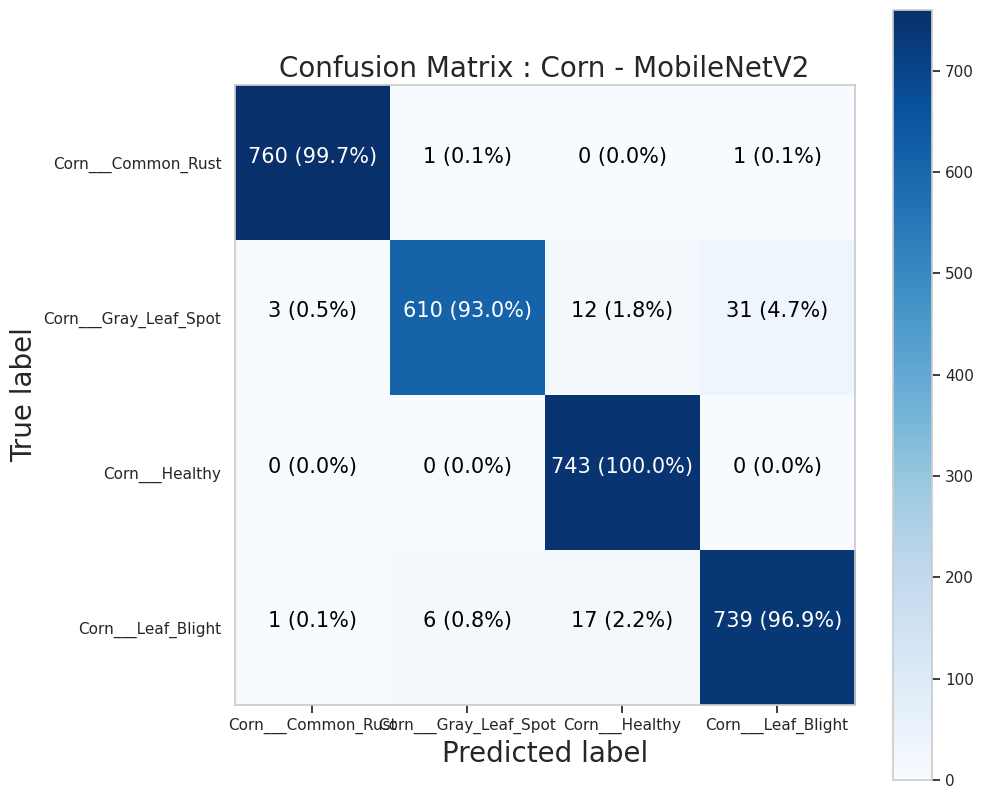

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

figsize = (10, 10)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred )
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Create classes
classes = True

if classes:
  labels = class_names
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix : Corn - MobileNetV2",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

threshold = (cm.max() + cm.min()) / 2.

plt.grid(False)

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)
plt.savefig('/content/drive/MyDrive/SIH-Models/Corn/Model-CM')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true , y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       762
           1       0.99      0.93      0.96       656
           2       0.96      1.00      0.98       743
           3       0.96      0.97      0.96       763

    accuracy                           0.98      2924
   macro avg       0.98      0.97      0.97      2924
weighted avg       0.98      0.98      0.98      2924



## 2) Float16 Qauntized Model

In [ ]:
model = load_model('/content/drive/MyDrive/SIH-Models/Corn/corn_mobilenetv2.h5')

In [ ]:


# Convert the Keras model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('/content/drive/MyDrive/SIH-Models/Corn/corn_mobilenetv2.tflite', 'wb') as f:
    f.write(tflite_model)

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/SIH-Models/Corn/corn_mobilenetv2.tflite')
interpreter.allocate_tensors()

# Quantization using float16
converter_float16 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_float16.optimizations = [tf.lite.Optimize.DEFAULT]
converter_float16.target_spec.supported_types = [tf.float16]
tflite_model_float16 = converter_float16.convert()

# Save the float16 quantized TFLite model
with open('/content/drive/MyDrive/SIH-Models/Corn/corn_mobilenetv2_float16.tflite', 'wb') as f:
    f.write(tflite_model_float16)

In [ ]:
import numpy as np

# Initialize lists to store test images and labels
test_imgs = []
test_labels = []

# Loop through the test generator to collect images and labels
for _ in range(len(validation_generator)):
    batch = validation_generator.next()  # Get the next batch from the iterator
    batch_images, batch_labels = batch  # Extract images and labels from the batch

    # Append the batch of images and labels to the respective lists
    test_imgs.extend(batch_images)
    test_labels.extend(batch_labels)

# Convert the lists to NumPy arrays
test_imgs = np.array(test_imgs)
test_labels = np.array(test_labels)

In [ ]:
TF_LITE_MODEL_FILE_NAME = "/content/drive/MyDrive/SIH-Models/Corn/corn_mobilenetv2_float16.tflite"

In [ ]:

interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 4]
Output Type: <class 'numpy.float32'>


In [ ]:
2924 // 4

731

In [ ]:

interpreter.resize_tensor_input(input_details[0]['index'], (731, 224,224,3 ))
interpreter.resize_tensor_input(output_details[0]['index'], (731, 4))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [731 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [731   4]
Output Type: <class 'numpy.float32'>


In [ ]:
test_imgs.shape
len(test_imgs)

2924

In [ ]:
tflite_model_predictions = np.empty((len(test_imgs), 4))  # Initialize with the correct shape

for start in range(0, len(test_imgs), 731):
    test_batch = test_imgs[start: start + 731]
    interpreter.set_tensor(input_details[0]['index'], test_batch)
    interpreter.invoke()
    tflite_model_pred = interpreter.get_tensor(output_details[0]['index'])
    tflite_model_predictions[start: start + 731] = tflite_model_pred  # Assign predictions to the corresponding batch

print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)


Prediction results shape: (2924, 4)


In [ ]:
prediction_classes.shape

(2924,)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(test_labels , axis=1) , prediction_classes))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       762
           1       0.99      0.94      0.96       656
           2       0.97      1.00      0.99       743
           3       0.96      0.98      0.97       763

    accuracy                           0.98      2924
   macro avg       0.98      0.98      0.98      2924
weighted avg       0.98      0.98      0.98      2924



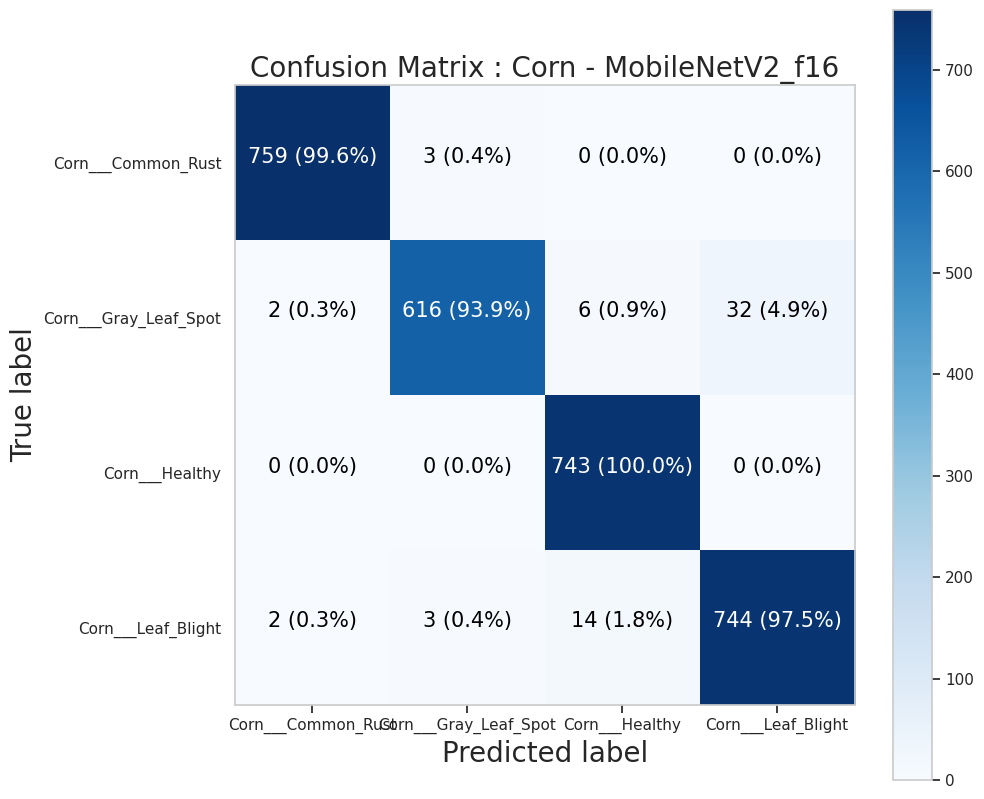

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools


figsize = (10, 10)

# Create the confusion matrix
cm = confusion_matrix(np.argmax(test_labels , axis=1) , prediction_classes)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Create classes
classes = True

if classes:
  labels = class_names
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix : Corn - MobileNetV2_f16",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)
plt.grid(False)
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)
plt.savefig('/content/drive/MyDrive/SIH-Models/Corn/Modelfloat16-CM')

### 3) INT8 Qauntized Model

In [ ]:

# Load your trained Keras model in .h5 format
keras_model = load_model("/content/drive/MyDrive/SIH-Models/Corn/corn_mobilenetv2.h5")  # Replace with your model path

# Create the TFLite converter
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.int8]


generator = Image_datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset = 'validation'
)

num_calibration_steps = 20
def representative_data_gen():
    for batch_idx in range(num_calibration_steps):
        batch = generator.next()  # Get the next batch
        yield [batch[0]]  # Yield the batch inputs

# Set the representative dataset using the generator function
converter.representative_dataset = representative_data_gen

# Convert the model to quantized TFLite format
tflite_model_quantized = converter.convert()

# Save the quantized TFLite model
with open('/content/drive/MyDrive/SIH-Models/Corn/corn_mobilenetv2_int8.tflite', 'wb') as f:
    f.write(tflite_model_quantized)

Found 2924 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
TF_LITE_MODEL_FILE_NAME = "/content/drive/MyDrive/SIH-Models/Corn/corn_mobilenetv2_int8.tflite"

In [ ]:

interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 4]
Output Type: <class 'numpy.float32'>


In [ ]:

interpreter.resize_tensor_input(input_details[0]['index'], (731, 224,224,3 ))
interpreter.resize_tensor_input(output_details[0]['index'], (731, 3))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [731 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [731   4]
Output Type: <class 'numpy.float32'>


In [ ]:
tflite_model_predictions = np.empty((len(test_imgs), 4))  # Initialize with the correct shape

for start in range(0, len(test_imgs), 731):
    test_batch = test_imgs[start: start + 731]
    interpreter.set_tensor(input_details[0]['index'], test_batch)
    interpreter.invoke()
    tflite_model_pred = interpreter.get_tensor(output_details[0]['index'])
    tflite_model_predictions[start: start + 731] = tflite_model_pred  # Assign predictions to the corresponding batch

print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)


Prediction results shape: (2924, 4)


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(test_labels , axis=1) , prediction_classes))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       762
           1       0.99      0.95      0.97       656
           2       0.98      1.00      0.99       743
           3       0.97      0.98      0.97       763

    accuracy                           0.98      2924
   macro avg       0.98      0.98      0.98      2924
weighted avg       0.98      0.98      0.98      2924



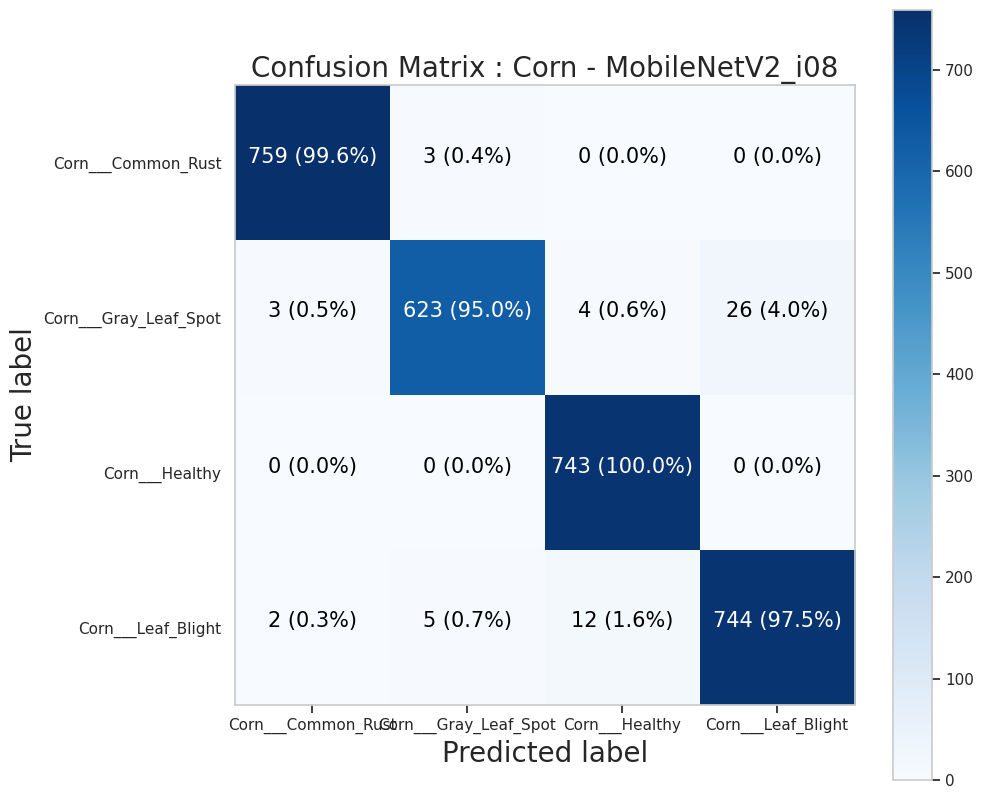

In [ ]:
figsize = (10, 10)

# Create the confusion matrix
cm = confusion_matrix(np.argmax(test_labels , axis=1) , prediction_classes)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Create classes
classes = True

if classes:
  labels = class_names
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix : Corn - MobileNetV2_i08",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

threshold = (cm.max() + cm.min()) / 2.
plt.grid(False)
# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)
plt.savefig('/content/drive/MyDrive/SIH-Models/Corn/Modelint8-CM')

---